# Bayesian estimation and regression with pymc3

We can convert frequentist models we have been using before to their Bayesian counterparts. In this lab we will be starting incrementally: replacing the frequentist t-test with Bayesian estimation as well as performing a Bayesian regression with one predictor.

---

### Load packages

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#### pymc3 is the bayesian modeling package used in this lab

There is also pymc (or pymc2) which has a different syntax. pymc2 is in my opinion harder for beginners to Bayesian statistics to understand; pymc3 bridges the gap better for those who are more familiar with constructing models using frequentist style models/syntax.

In [8]:
import pymc3 as pm

---

### Starcraft dataset

This dataset has records of different player statistics while they are playing Starcraft competitively. There are a variety of columns that are described in detail within the `description.txt` folder contained inside the same folder.

For the examples in this lab, I will be using APM (actions per minute) and Age, but I recommend looking at other variables as well.

In [9]:
star = pd.read_csv('/Users/kiefer/github-repos/DSI-SF-4/datasets/starcraft/SkillCraft1_Dataset.csv')

In [10]:
star.head()

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,52,5,27,10,3000,143.7180,0.003515,0.000220,7,0.000110,0.000392,0.004849,32.6677,40.8673,4.7508,28,0.001397,6,0.0,0.000000
1,55,5,23,10,5000,129.2322,0.003304,0.000259,4,0.000294,0.000432,0.004307,32.9194,42.3454,4.8434,22,0.001194,5,0.0,0.000208
2,56,4,30,10,200,69.9612,0.001101,0.000336,4,0.000294,0.000461,0.002926,44.6475,75.3548,4.0430,22,0.000745,6,0.0,0.000189
3,57,3,19,20,400,107.6016,0.001034,0.000213,1,0.000053,0.000543,0.003783,29.2203,53.7352,4.9155,19,0.000426,7,0.0,0.000384
4,58,3,32,10,500,122.8908,0.001136,0.000327,2,0.000000,0.001329,0.002368,22.6885,62.0813,9.3740,15,0.001174,4,0.0,0.000019


---

## Alternative to t-testing with Bayesian estimation

[This example is adapted from the documentation here.](http://pymc-devs.github.io/pymc3/notebooks/BEST.html) In the example the student-t distribution is used instead of the normal distribution like I use below. This is more appropriate, but more complicated due to the parameterization of the t-distribution. If you're feeling bold try doing this with the t-distribution like in the documentation!

In the following code, I will be using Bayesian posterior estimation to look at the difference in APM between 19 year old players and 26 year old players.

In frequentist statistics, calculating the mean difference between groups is typically done with a t-test. In a t-test we state a null hypothesis (H0) that there is no diffference between groups, then evaluate the probability that we could have gotten this data when the null hypothesis is true.

The de facto standard for statistically comparing two (or more) samples is to use a statistical test. This involves expressing a null hypothesis, which typically claims that there is no difference between the groups, and using a chosen test statistic to determine whether the distribution of the observed data is plausible under the hypothesis. This rejection occurs when the calculated test statistic is higher than some pre-specified threshold value.

The bayesian approach for evaluating differences between groups is "estimation" rather than "testing". Instead of asking "are the two groups different?", we instead ask "_how_ different are the two groups?" This is the subtle difference in estimation as opposed to testing. We are measuring the extent of the difference between the groups, whether it is zero or any other value.

For a more detailed treatment feel free to read the documentation linked above.

---

### Load 19 year olds and 26 year olds

In [11]:
apm19 = star[star.Age == '19'].APM.values
apm26 = star[star.Age == '26'].APM.values

In [12]:
print apm19.shape, apm26.shape

(313,) (136,)


In [13]:
print apm19.mean(), apm26.mean(), apm26.mean()-apm19.mean()

121.689559744 104.741840735 -16.9477190091


In [14]:
import scipy.stats as stats

In [16]:
tt = stats.ttest_ind(apm19, apm26)

In [17]:
tt.statistic

3.5501270512716077

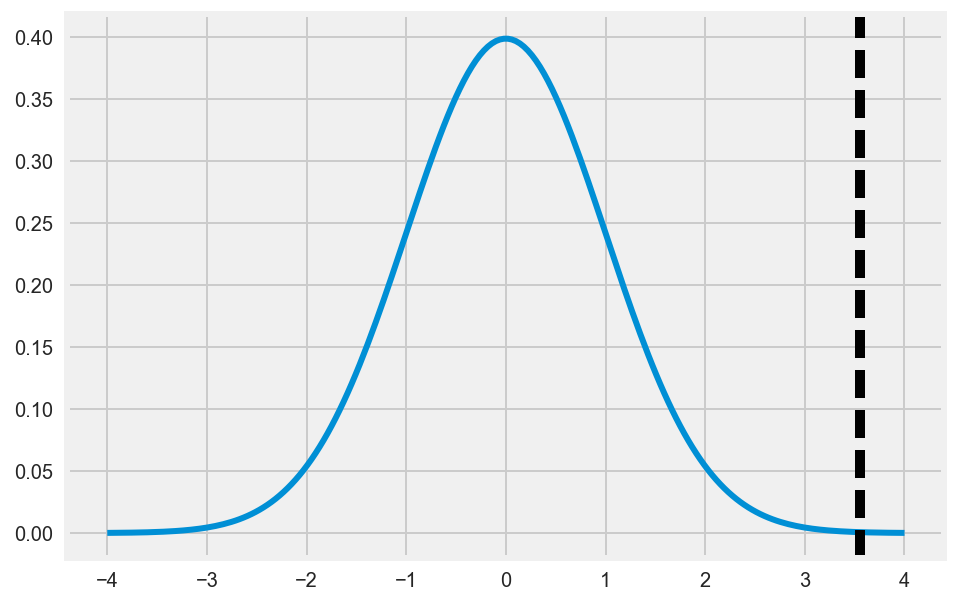

In [18]:
zdist = stats.norm(0, 1)
xvals = np.linspace(-4, 4, 200)

fig, ax = plt.subplots(figsize=(7,5))
ax.plot(xvals, zdist.pdf(xvals), lw=3)
ax.axvline(tt.statistic, color='black', ls='dashed', lw=5)
plt.show()

In [19]:
1. - zdist.cdf(tt.statistic)

0.0001925226376960909

---

### Set up the bayesian model and priors on means

First we find the mean and standard deviation of APM regardless of age group. We are going to use these values to inform our priors, or current beliefs about APM.

In [20]:
mean_prior_mean = star.APM.mean()
mean_prior_std = star.APM.std()

print mean_prior_mean, mean_prior_std

117.046947093 51.9452909868


pymc3 sets up models using the `with ... :` syntax in python.

The first thing we are going to set up is our prior belief about the mean APM for our 19 year olds and 26 year olds. _These are not fixed values,_ but rather normal distributions covering a range of possible values for the mean APM for each group with varying likelihoods.

We are going to set up the normal distributions to both take the overall mean and standard deviation of the actions per minute for all players. In other words, our prior belief for each group's mean APM is the same.

In [39]:
with pm.Model() as model:
    
    group19_mean = pm.Normal('APM_19yo_mean', mean_prior_mean, sd=mean_prior_std)
    group26_mean = pm.Normal('APM_26yo_mean', mean_prior_mean, sd=mean_prior_std)
    
    

---

### Priors on standard deviations

What we set up before are the prior distributions for the _means_ of APM for the two age groups, but we can also set up priors on the standard deviations for APM for each group. In fact, we have to have a prior belief about the distribution of APM for each age group.

Our standard deviation priors will be uniformly distributed from close to 0 up to 100. This is an uninformative prior, saying that we believe all standard deviations in those ranges to be equally likely.

In [40]:
std_prior_lower = 0.00001
std_prior_upper = 5.

with model:
    
    group19_std = pm.Uniform('APM_19yo_std', lower=std_prior_lower, upper=std_prior_upper)
    group26_std = pm.Uniform('APM_26yo_std', lower=std_prior_lower, upper=std_prior_upper)
    

---

### Set up the APM distributions for groups

Now that we have our prior beliefs about the mean and standard deviation of APM for each age group, we can construct what will be the posterior distributions for the APMs after we have observed the data.

For each group we set up a `pm.Normal` distribution to represent the posterior APM. The mean `mu=` will be our prior belief distribution of the mean for that group. Likewise the `sd=` will be the prior distribution for standard deviation of APM for that group. 

Lastly, we give the posteriors an `observed=` parameter which is the actual APM data. When we "fit" this model using MCMC, the posterior distributions will be updated according to our prior beliefs and our data just like in Bayes formula.

In [41]:
with model:
    group19 = pm.Normal('APM_19yo', mu=group19_mean, sd=group19_std, observed=apm19)
    group26 = pm.Normal('APM_26yo', mu=group26_mean, sd=group26_std, observed=apm26)
    

---

### Defining additional metrics

The last thing we'll do before fitting the model is defining some distributions that will help us evaluate our question about differences between mean APMs. 

The `pm.Deterministic` distributions are defined from other distributions in the model. For example, below we set up `diff_of_means` to be defined by `group19_mean - group26_mean`, making this a distribution of the differences between means between groups as the posteriors are iteratively fit/estimated.

Effect size is something we have not covered, but it is a normalized measure of the strength of a difference between measures (typically means). We take the difference between means and divide by the pooled standard deviation. Our effect size is guaranteed to lie betweeen -1 and 1, with 0 indicating no difference.

In [42]:
with model:
    diff_of_means = pm.Deterministic('mean_diff', group19_mean - group26_mean)
    diff_of_stds = pm.Deterministic('std_diff', group19_std - group26_std)
    effect_size = pm.Deterministic('effect_size', diff_of_means / np.sqrt((group19_std**2 + group26_std**2)/2.))

---

### Fitting the model with MCMC

When we call `trace = pm.sample(...)` we are starting the process of Markov Chain Monte Carlo (MCMC) estimation of posteriors. The details of thi process we will be covering soon, but essentially it is a sampling algorithm that lets us construct arbitrary posterior distributions given our data and priors.

You'll see "NUTS" being printed out when it is run, along with a progress bar. "NUTS" stands for No U-Turn Sampler and is a state-of-the-art MCMC algorithm.

The "trace" is a collection of all the values on the posterior distribution visited by the MCMC sampling. The values in the trace define the posterior distribution.

In [43]:
with model:
    trace = pm.sample(10000, njobs=4)

Average ELBO = -20,481: 100%|██████████| 200000/200000 [00:21<00:00, 9392.74it/s]
ERROR (theano.gof.opt): Optimization failure due to: LocalOptGroup(use_c_ger,use_c_gemv)
ERROR (theano.gof.opt): node: Gemv{no_inplace}(AllocEmpty{dtype='float64'}.0, TensorConstant{1.0}, Elemwise{mul,no_inplace}.0, p, TensorConstant{0.0})
ERROR (theano.gof.opt): TRACEBACK:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "//anaconda/lib/python2.7/site-packages/theano/gof/opt.py", line 1922, in process_node
    replacements = lopt.transform(node)
  File "//anaconda/lib/python2.7/site-packages/theano/gof/opt.py", line 1309, in transform
    new_repl = opt.transform(node)
  File "//anaconda/lib/python2.7/site-packages/theano/tensor/blas_c.py", line 674, in use_c_gemv
    if not config.blas.ldflags:
  File "//anaconda/lib/python2.7/site-packages/theano/configparser.py", line 320, in __get__
    val_str = self.default()
  File "//anaconda/lib/python2.7/site-packages/theano/configdefaults.py",

---

### Plotting posteriors and result distributions

pymc3 comes with convenient methods for plotting posteriors. Below we plot our posterior means and standard deviations and statistics about the distributions are automatically given to us on the plots.

The HPD is the Highest Posterior Density interval. This gives us a bayesian "credible interval" which is the corollary to the frequentist confidence interval. The 95% HPD says that the 95% highest density points on the distribution fall within that range.

In [33]:
trace[0]

{'APM_19yo_mean': 121.86618705307013,
 'APM_19yo_std': 47.679162355579699,
 'APM_19yo_std_interval_': -5.3410668081468016,
 'APM_26yo_mean': 107.62537146846547,
 'APM_26yo_std': 44.504781790212014,
 'APM_26yo_std_interval_': -5.4102835462734893,
 'effect_size': 0.30878218364223048,
 'mean_diff': 14.240815584604661,
 'std_diff': 3.1743805653676844}

In [35]:
apm19.mean()

121.68955974440894

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11f189650>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x12094a690>], dtype=object)

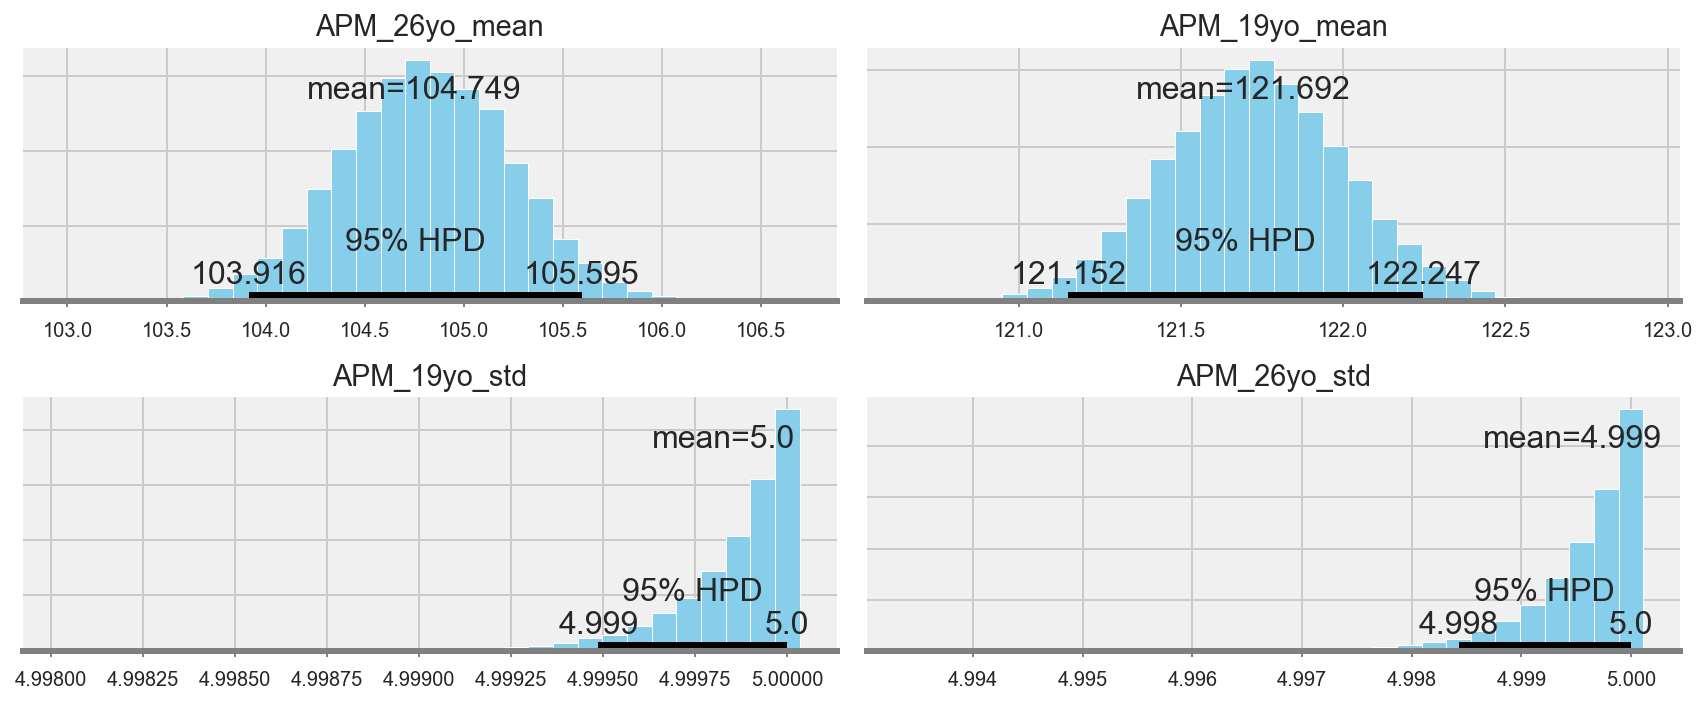

In [44]:
pm.plot_posterior(trace[3000:],
                  varnames=['APM_19yo_mean', 'APM_26yo_mean',
                            'APM_19yo_std', 'APM_26yo_std'],
                 color='#87ceeb')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11a20c110>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x11847f050>], dtype=object)

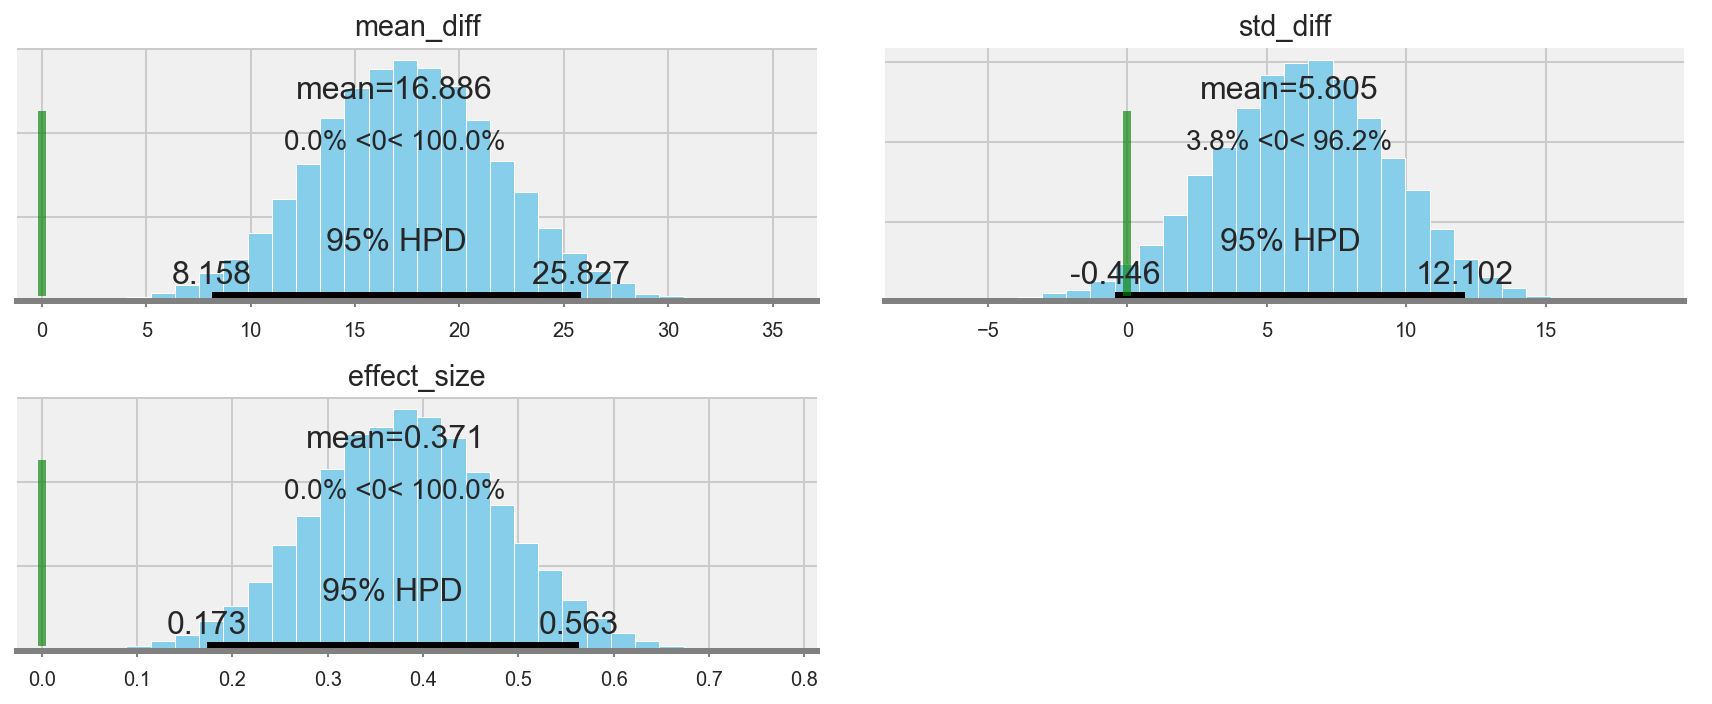

In [37]:
pm.plot_posterior(trace[3000:],
                  varnames=['mean_diff', 'std_diff','effect_size'],
                 color='#87ceeb', ref_val=0)

In [38]:
pm.summary(trace[3000:],varnames=['mean_diff', 'std_diff','effect_size'])


mean_diff:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  16.886           4.496            0.028            [8.158, 25.827]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  8.024          13.862         16.862         19.887         25.728


std_diff:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  5.805            3.208            0.017            [-0.446, 12.102]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.650         3.683          5.872          7.991          11.912


effect_size:

  Mean             SD               MC Error         95% HPD interval
  -------

In [48]:
#EFFECT SIZE
mean19 = apm19.mean()
mean26 = apm26.mean()
mean_diff = mean19 - mean26
print mean_diff

pooled_std = np.sqrt((apm19.var() + apm26.var())/2.)
print pooled_std

16.9477190091
45.2024153181


In [49]:
print apm19.std(), apm26.std()

48.1297572917 42.0718809209


In [50]:
mean_diff/pooled_std

0.37492950077678788

We can also plot out our distributions that we defined to explicitly measure the statistics we were interested in, like the difference in mean APM between the groups.

The `ref_val` will plot a vertical bar at any value you like to give you a visual reference. In this case, we will choose 0 since we want to see if a portion of our mean difference ditribution overlaps 0.

Lastly, you can use the `pm.summary` command to print out a text representation of the statistics for the posterior distributions above.

---

## Perform your own comparison with pymc3

Following the code above, choose groups and values to compare by group using the same Bayesian posterior estimation process.

Try playing around with the parameters for the priors. What happens if you make the range of the prior distributions too small?

---

## Bayesian regression using pymc3

We can use the same kind of model setup to perform Bayesian-style regressions as well. [This example is modeled after the generalized linear model (GLM) instructions in the pymc3 documentation.](http://pymc-devs.github.io/pymc3/notebooks/GLM-linear.html)

What are the benefits to taking a Bayesian approach to regression modeling? Just like in our estimation of APM means per group in the above example, when we perform regression with Bayesian statistics we will get out posterior distributions on our intercept and coefficients. This makes it easy to see the entire distribution of possibilities for these coefficients and shows us immediately the degree of uncertainty in our estimate of an effect.

---

### Set up age vs. APM

In [51]:
star.Age.unique()

array(['27', '23', '30', '19', '32', '21', '17', '20', '18', '16', '26',
       '38', '28', '25', '22', '29', '24', '35', '31', '33', '37', '40',
       '34', '43', '41', '36', '44', '39', '?'], dtype=object)

In [52]:
s = star[star.Age != '?']
s['Age'] = s.Age.map(lambda x: float(x))

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [53]:
s.Age.mean()

21.647904191616767

In [54]:
s.isnull().sum()

GameID                  0
LeagueIndex             0
Age                     0
HoursPerWeek            0
TotalHours              0
APM                     0
SelectByHotkeys         0
AssignToHotkeys         0
UniqueHotkeys           0
MinimapAttacks          0
MinimapRightClicks      0
NumberOfPACs            0
GapBetweenPACs          0
ActionLatency           0
ActionsInPAC            0
TotalMapExplored        0
WorkersMade             0
UniqueUnitsMade         0
ComplexUnitsMade        0
ComplexAbilitiesUsed    0
dtype: int64

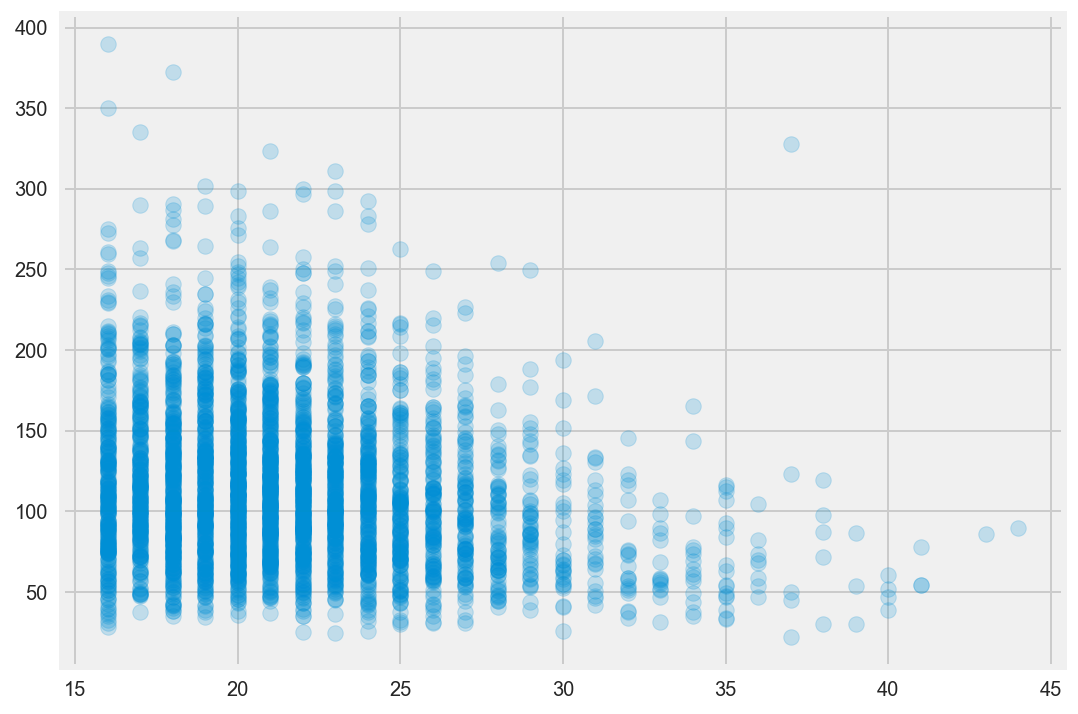

In [55]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(s.Age.values, s.APM.values, s=60, alpha=0.2)
plt.show()

---

### Setting up the Bayesian regression model

Like before, we will construct our model with the `with pm.Model() ...` syntax. 

We have three prior distributions in this case that will be updated to posterior with the data:

1. `apm_std`: which will be our prior belief about the standard deviation of APM values. In this case I am setting it to be uniform (uninformative) between 0.01, and 100..
- `intercept`: a normal distribution for the range of possible values of the intercept.
- `age_beta`: a normal distribution for the range of possible values of the age coefficient.

We set up a `likelihood` distribution that is also normal, representing the distribution of the data (APM) given our predictor. The mean of the likelihood is defined like a regression formula: our intercept distribution plus the age values times our age beta distribution. We give the `apm_std` uniform prior as the standard deviation. Lastly, the observed values, or data, will be the APM values.

What will happen here as MCMC samples is that more likely values (as defined by the mu= regression-style definition) will be "visited" more often. The intercept and age_beta distributions in tandem will have more values visited in places where they result in higher likelihood estimates.

`pm.find_MAP()` tries to find good starting values for our MCMC procedure so that we don't have to run it for as many iterations to get a good posterior representation.

In [56]:
apm_age = s[['APM','Age']]

In [58]:
with pm.Model() as reg:
    apm_std = pm.Uniform('error_std', lower=0.0001, upper=10000.)
    
    intercept = pm.Uniform('intercept', lower=-10000., upper=10000.)
    age_beta = pm.Uniform('age_beta', lower=-200., upper=200.)
    
    # apm ~ b0 + b1 * age
    # E[apm]
    
    E_apm = pm.Normal('y_mean', mu=intercept + (age_beta * apm_age.Age.values),
                      sd=apm_std, observed=apm_age.APM.values)
    

In [59]:
with reg:
    step = pm.NUTS()
    trace = pm.sample(10000, step)

ERROR (theano.gof.opt): Optimization failure due to: LocalOptGroup(use_c_ger,use_c_gemv)
ERROR (theano.gof.opt): node: Gemv{no_inplace}(AllocEmpty{dtype='float64'}.0, TensorConstant{1.0}, Elemwise{mul,no_inplace}.0, p, TensorConstant{0.0})
ERROR (theano.gof.opt): TRACEBACK:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "//anaconda/lib/python2.7/site-packages/theano/gof/opt.py", line 1922, in process_node
    replacements = lopt.transform(node)
  File "//anaconda/lib/python2.7/site-packages/theano/gof/opt.py", line 1309, in transform
    new_repl = opt.transform(node)
  File "//anaconda/lib/python2.7/site-packages/theano/tensor/blas_c.py", line 674, in use_c_gemv
    if not config.blas.ldflags:
  File "//anaconda/lib/python2.7/site-packages/theano/configparser.py", line 320, in __get__
    val_str = self.default()
  File "//anaconda/lib/python2.7/site-packages/theano/configdefaults.py", line 1273, in default_blas_ldflags
    lib_path = blas_info.get('library_dirs', [

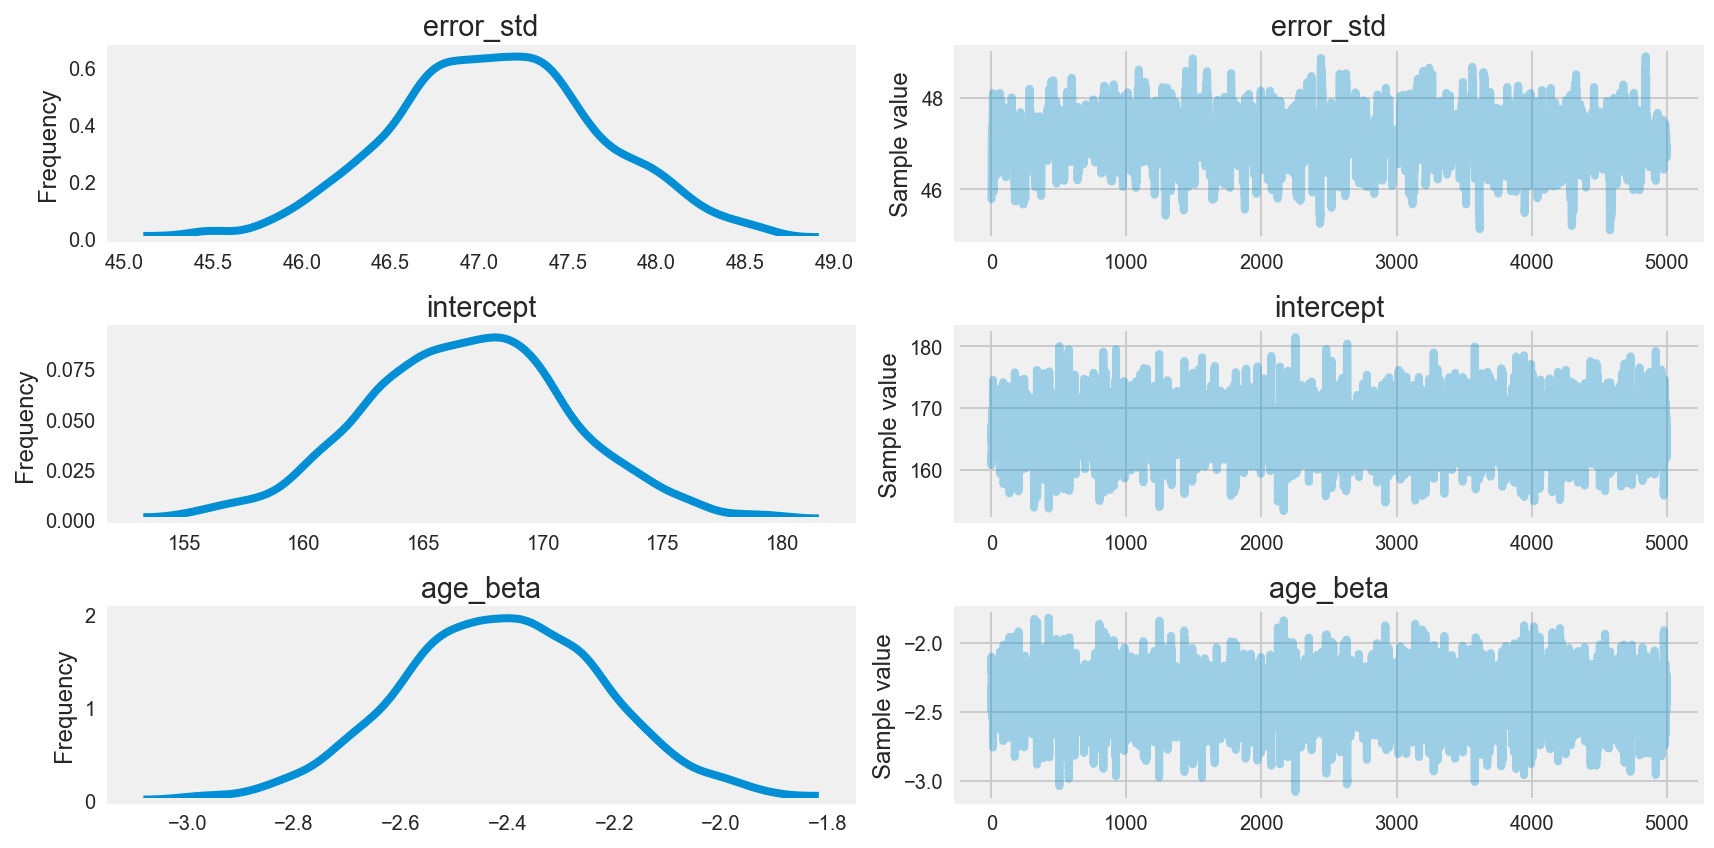

In [63]:
plt.figure(figsize=(7,7))
pm.traceplot(trace[5000:])
plt.tight_layout()

`pm.traceplot` can be used to look at the distributions we created in the model across iterations of the MCMC sampling algorithm.

---

### Setting up the model in patsy-style syntax

pymc3 also gives you a convenience function `pm.glm.glm(...` which takes a patsy-style formula definition and the dataframe, and automatically constructs the distributions required to solve the Bayesian regression. Pretty nice.

In [64]:
with pm.Model() as reg:
    pm.glm.glm('APM ~ Age', apm_age)
    trace = pm.sample(5000)

ERROR (theano.gof.opt): Optimization failure due to: LocalOptGroup(use_c_ger,use_c_gemv)
ERROR (theano.gof.opt): node: Gemv{no_inplace}(AllocEmpty{dtype='float64'}.0, TensorConstant{1.0}, TensorConstant{[[  1.  27.. 1.  22.]]}, MakeVector{dtype='float64'}.0, TensorConstant{0.0})
ERROR (theano.gof.opt): TRACEBACK:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "//anaconda/lib/python2.7/site-packages/theano/gof/opt.py", line 1922, in process_node
    replacements = lopt.transform(node)
  File "//anaconda/lib/python2.7/site-packages/theano/gof/opt.py", line 1309, in transform
    new_repl = opt.transform(node)
  File "//anaconda/lib/python2.7/site-packages/theano/tensor/blas_c.py", line 674, in use_c_gemv
    if not config.blas.ldflags:
  File "//anaconda/lib/python2.7/site-packages/theano/configparser.py", line 320, in __get__
    val_str = self.default()
  File "//anaconda/lib/python2.7/site-packages/theano/configdefaults.py", line 1273, in default_blas_ldflags
    li

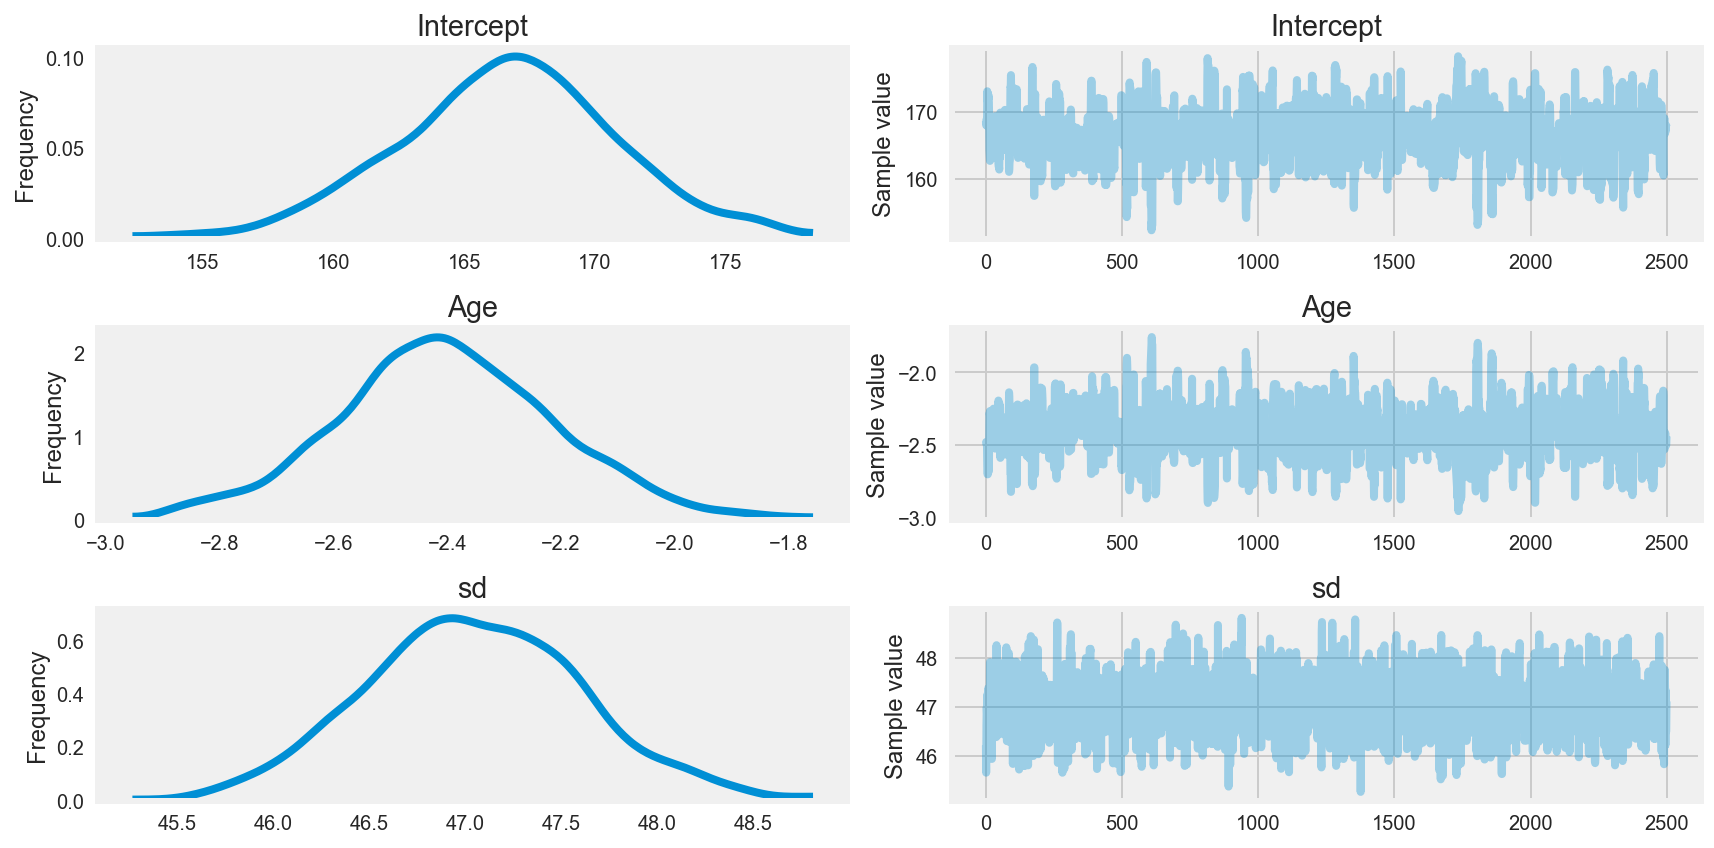

In [66]:
plt.figure(figsize=(7,7))
pm.traceplot(trace[2500:])
plt.tight_layout()

Lastly, you can plot out different possible regression lines with `pm.glm.plot_posterior_predictive`.

This function takes:

- the trace (MCMC samples)
- the number of samples you want to draw out and plot
- an `lm=` argument that will be a function defining how the regression line will be fit using an x value and the sample
- an `eval=` argument that will be the x-values `lm` is evaluated over

---

## Perform your own Bayesian regression

Following the Bayesian regression code above, choose a target and predictor and fit a regression model using pymc3.

Fit the same linear regression using sklearn. Are the values for the intercept and the coefficients different? How does changing the parameterization for the prior distributions affect the values of the intercept and coefficients?